In [10]:
import os

import librosa, librosa.display
import IPython.display as ipd
from random import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from ser_helpers import data_manager
from ser_helpers import augmentation

EMOTIONS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']


In [11]:
# AUG_DATA_PATH = '../data/df_all_aug.pkl'
# df = pd.read_pickle(AUG_DATA_PATH)
#
# df_train = df[df["usage"] == "train"]
# df_test = df[df["usage"] == "test"]
#
# X_train = np.stack(df_train['mfcc'].to_numpy())
# X_train = X_train[..., np.newaxis]
# y_train = np.stack(df_train['emotion'].to_numpy())
#
# X_test = np.stack(df_test['mfcc'].to_numpy())
# X_test = X_test[..., np.newaxis]
# y_test = np.stack(df_test['emotion'].to_numpy())
#
# print(X_train.shape)

In [12]:
def build_model(input_shape):

    # create model
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(axis=1))

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(axis=1))

    # flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(8, activation='softmax'))

    return model

In [13]:
# for aug_comb in augmentation.aug_combinations:
#     X_train, y_train, X_test, y_test = data_manager.get_augmented_data(aug_comb)
#
#     #cnn specific
#     X_train = X_train[..., np.newaxis]
#     X_test = X_test[..., np.newaxis]
#
#     input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
#     model = build_model(input_shape)
#
#     # compile network
#     optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#     model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#
#     history = model.fit(
#         X_train,
#         y_train,
#         validation_data=(X_test, y_test),
#         epochs=90,
#         batch_size=16,
#         verbose=0
#     )
#
#     # evaluate the CNN on the test set
#     test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
#     print(aug_comb)
#     print("Accuracy on test set is: {}".format(str(round(100 * test_accuracy, 2))))
#     print()

In [21]:
X_train, y_train, X_test, y_test = data_manager.get_augmented_data([augmentation.AUG_STRETCH])

#cnn specific
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

shuffle it


In [22]:
i = 1
# for i in range(1, 21):
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

# compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=90,
    batch_size=16,
    verbose=0
)

# evaluate the CNN on the test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print()
print("Run {}: Accuracy on test set is: {}".format(i, str(round(100 * test_accuracy, 2))))
print()

288/288 [==============================] - 0s 490us/sample - loss: 1.2275 - accuracy: 0.7188

Run 1: Accuracy on test set is: 71.88



In [16]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Präzision")
    axs[0].set_xlabel("Epoche")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoche")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.tight_layout()
    plt.show()
    # plt.savefig('../plots/cnn_150_epochs_with_anti-overfitting_and_batchnorm.png')

In [17]:
#model.save("../models/cnn_top_performing.h5")

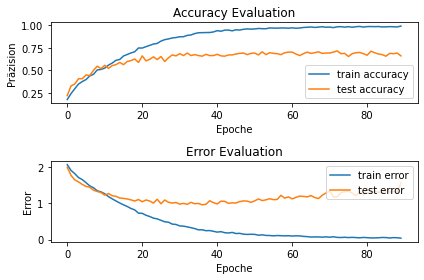

In [18]:
plot_history(history)